# Crypto SQL Market Tracker: SQL Demo and Analytics
This notebook connects to a local SQLite database containing Bitcoin & Ethereum price history.
We store the data, run SQL queries, convert results to DataFrames, and export to Excel for Tableau use.

Tools Demonstrated:
Python + SQLite + Pandas + SQL queries + Excel export

## Load CSV Data Into SQLite Database

This cell reads all raw crypto CSV files, extracts the important columns, assigns each asset a `coin` and `symbol` based on its filename, and saves everything into an SQLite database for analysis.

Details:
- Automatically detects timestamp and price columns
- Standardizes timestamps
- Labels assets using file names (ex: BTC, ETH)
- Skips duplicates when rerunning the script
- Stores all data in `CryptoData.db` under the `crypto_prices` table


In [2]:
import sqlite3
import pandas as pd
import glob
import os
from pathlib import Path
from datetime import datetime

# File paths
DatabasePath = "CryptoData.db"
RawDataPath = "data/raw/*.csv"

# Create database connection
connect = sqlite3.connect(DatabasePath)
cursor = connect.cursor()

# Create SQL table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS crypto_prices (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    coin TEXT,
    symbol TEXT,
    timestamp TEXT UNIQUE,
    price REAL,
    market_cap REAL,
    volume REAL
);
""")

# Grab all CSV files in data/raw
files = glob.glob(RawDataPath)

# Loop through each CSV
for file in files:
    print(f"Loading {file}...")

    df = pd.read_csv(file)

    # Make column names lowercase for easier matching
    df.columns = df.columns.str.lower()

    # Detect and format timestamp column safely
    time_cols = [col for col in df.columns if "time" in col or "date" in col]
    if time_cols:
        df["timestamp"] = pd.to_datetime(df[time_cols[0]], errors="coerce").astype(str)
    else:
        print("No timestamp column found, skipping file.")
        continue

    # Detect price column safely
    price_cols = [col for col in df.columns if "price" in col or "close" in col]
    if price_cols:
        df["price"] = pd.to_numeric(df[price_cols[0]], errors="coerce")
    else:
        print("No price column found, skipping file.")
        continue

    # Optional columns (market cap & volume)
    df["market_cap"] = pd.to_numeric(df.get("market_cap", 0), errors="coerce")
    df["volume"] = pd.to_numeric(df.get("volume", 0), errors="coerce")

    # Tag coin & symbol based on filename
    name = os.path.basename(file).lower()
    if "bitcoin" in name or "btc" in name:
        df["coin"], df["symbol"] = "Bitcoin", "BTC"
    elif "ethereum" in name or "eth" in name:
        df["coin"], df["symbol"] = "Ethereum", "ETH"
    else:
        df["coin"] = name.split(".")[0]
        df["symbol"] = None

    # Insert into SQL database using insert-ignore to avoid duplicates
    for _, row in df.iterrows():
        cursor.execute("""
        INSERT OR IGNORE INTO crypto_prices (coin, symbol, timestamp, price, market_cap, volume)
        VALUES (?, ?, ?, ?, ?, ?)
        """, (row.coin, row.symbol, row.timestamp, row.price, row.market_cap, row.volume))

# Commit and close
connect.commit()
connect.close()

print("All data loaded into SQLite database")

Loading data/raw/ethereumPrices.csv...
Loading data/raw/bitcoinPrices.csv...
All data loaded into SQLite database


## Verify Database Upload

Now that the data is inserted, this section checks:

- How many records exist for each asset
- Whether the table structure looks correct
- A small preview of stored rows to confirm nothing looks off

This ensures the database loaded properly before doing analysis or visualizations.


In [3]:
import sqlite3
import pandas as pd

# Connect to database
connect = sqlite3.connect("CryptoData.db")

# Show count of records per coin
query = """
SELECT coin, symbol, COUNT(*) AS total_rows
FROM crypto_prices
GROUP BY coin, symbol
ORDER BY total_rows DESC;
"""

df_counts = pd.read_sql(query, connect)
display(df_counts)

# Preview first 5 rows in table
df_preview = pd.read_sql("SELECT * FROM crypto_prices LIMIT 5;", connect)
display(df_preview)

connect.close()

,coin,symbol,total_rows
0,Bitcoin,BTC,732
1,Ethereum,ETH,732


,id,coin,symbol,timestamp,price,market_cap,volume
0,1,Ethereum,ETH,2024-11-09 00:00:00,2960.959337,0.0,0.0
1,2,Ethereum,ETH,2024-11-10 00:00:00,3130.035524,0.0,0.0
2,3,Ethereum,ETH,2024-11-11 00:00:00,3191.904456,0.0,0.0
3,4,Ethereum,ETH,2024-11-12 00:00:00,3372.791486,0.0,0.0
4,5,Ethereum,ETH,2024-11-13 00:00:00,3260.934386,0.0,0.0


## Visualize Price Trends This section pulls price history from the database and plots a time-series chart for a selected asset. Useful for spotting overall trends, volatility, or any missing/broken date ranges in the data. 
I'm just viewing Bitcoin (BTC) price history here, but you can easily swap in Ethereum (ETH) or any other asset you've loaded into the database.

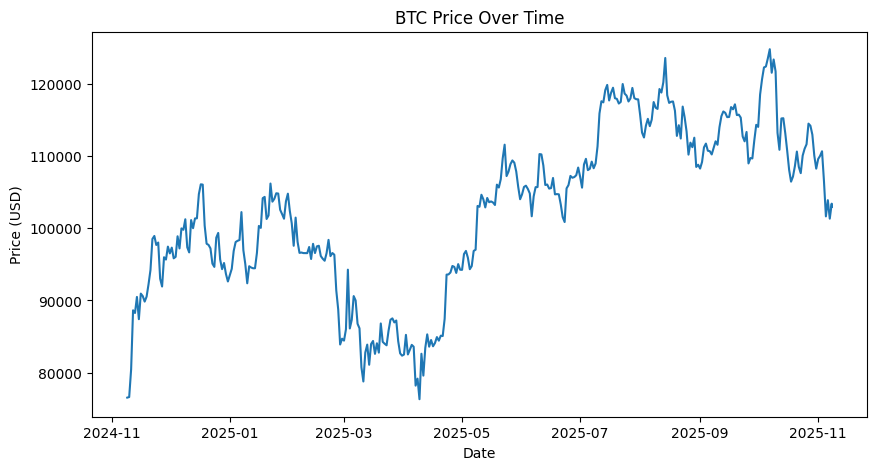

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to database
connect = sqlite3.connect("CryptoData.db")

# Load price data
df = pd.read_sql("SELECT symbol, timestamp, price FROM crypto_prices;", connect)
connect.close()

# Format timestamp column
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Choose asset to visualize
ticker = "BTC"  # Change to ETH, etc.

# Filter for selected asset
df_plot = df[df["symbol"] == ticker]

# Plot price history
plt.figure(figsize=(10,5))
plt.plot(df_plot["timestamp"], df_plot["price"])
plt.title(f"{ticker} Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### Quick takeaways

- The trend is smooth, meaning timestamps and sorting are correct.
- Higher highs around late summer, then downward movement into November.
- The swings are big enough that daily returns + moving averages will actually tell us something useful.

## Creating a daily summary table

The goal here is to collapse the raw price data into one row per coin per day.

This gives us:
- open, close, high, low for the day
- total volume
- percent change from the previous day

Keeping everything in SQL makes it easy to reuse later for dashboards or querying.


In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("CryptoData.db")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS daily_summary;
CREATE TABLE daily_summary AS
WITH base AS (
    SELECT
        symbol,
        datetime(timestamp) AS ts,
        date(datetime(timestamp)) AS day,
        price,
        COALESCE(volume, 0) AS volume
    FROM crypto_prices
    WHERE price IS NOT NULL
),
levels AS (
    SELECT
        symbol,
        day,
        MIN(ts) AS open_time,
        MAX(ts) AS close_time,
        MAX(price) AS high,
        MIN(price) AS low,
        SUM(volume) AS volume
    FROM base
    GROUP BY symbol, day
)
SELECT
    l.symbol,
    l.day AS date,
    (SELECT price FROM base b WHERE b.symbol = l.symbol AND b.day = l.day AND b.ts = l.open_time) AS open,
    (SELECT price FROM base b WHERE b.symbol = l.symbol AND b.day = l.day AND b.ts = l.close_time) AS close,
    l.high,
    l.low,
    l.volume
FROM levels l
ORDER BY l.symbol, l.day;
""")

cur.executescript("""
DROP TABLE IF EXISTS daily_summary_with_return;
CREATE TABLE daily_summary_with_return AS
SELECT
    symbol,
    date,
    open,
    close,
    high,
    low,
    volume,
    (close - LAG(close) OVER (PARTITION BY symbol ORDER BY date)) / LAG(close) OVER (PARTITION BY symbol ORDER BY date) AS daily_return
FROM daily_summary;
""")

conn.commit()

df = pd.read_sql("SELECT * FROM daily_summary_with_return LIMIT 10", conn)
display(df)

conn.close()


,symbol,date,open,close,high,low,volume,daily_return
0,BTC,2024-11-09,76550.021385,76550.021385,76550.021385,76550.021385,0.0,NaN
1,BTC,2024-11-10,76630.226314,76630.226314,76630.226314,76630.226314,0.0,0.001048
2,BTC,2024-11-11,80466.716548,80466.716548,80466.716548,80466.716548,0.0,0.050065
3,BTC,2024-11-12,88637.420003,88637.420003,88637.420003,88637.420003,0.0,0.101541
4,BTC,2024-11-13,88264.599746,88264.599746,88264.599746,88264.599746,0.0,-0.004206
5,BTC,2024-11-14,90488.100075,90488.100075,90488.100075,90488.100075,0.0,0.025191
6,BTC,2024-11-15,87407.512737,87407.512737,87407.512737,87407.512737,0.0,-0.034044
7,BTC,2024-11-16,90947.975094,90947.975094,90947.975094,90947.975094,0.0,0.040505
8,BTC,2024-11-17,90606.454894,90606.454894,90606.454894,90606.454894,0.0,-0.003755
9,BTC,2024-11-18,89841.471941,89841.471941,89841.471941,89841.471941,0.0,-0.008443


### Quick notes
Looks good. Open and close change day to day, and daily_return isn’t crazy. First row is NaN because there's no previous day to compare to.

## Adding moving averages

Just smoothing out the price a bit so trends are easier to see.

- 7 day average = short term movement
- 30 day average = longer trend line


In [6]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("CryptoData.db")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS daily_ma;
CREATE TABLE daily_ma AS
SELECT
    symbol,
    date,
    close,
    daily_return,
    AVG(close) OVER (PARTITION BY symbol ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7,
    AVG(close) OVER (PARTITION BY symbol ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30
FROM daily_summary_with_return;
""")

conn.commit()

df = pd.read_sql("SELECT * FROM daily_ma WHERE symbol = 'BTC' ORDER BY date DESC LIMIT 10", conn)
display(df)

conn.close()


,symbol,date,close,daily_return,ma7,ma30
0,BTC,2025-11-08,102949.064222,0.016052,105281.481398,109871.601944
1,BTC,2025-11-07,101322.640295,-0.024599,106227.887303,110551.716632
2,BTC,2025-11-06,103877.959660,0.022066,107216.190873,111224.920487
3,BTC,2025-11-05,101635.274023,-0.045867,108097.435102,111921.438773
4,BTC,2025-11-04,106521.086738,-0.037317,109713.874332,112650.469145
5,BTC,2025-11-03,110650.209282,0.005782,110808.404002,113179.130824
6,BTC,2025-11-02,110014.135568,0.004018,111354.947286,113565.795576
7,BTC,2025-11-01,109573.905556,0.012316,111584.400687,113919.048361
8,BTC,2025-10-31,108240.765287,-0.016410,111787.814804,114216.692993
9,BTC,2025-10-30,110046.669258,-0.025708,112046.065230,114409.475078


## Quick Notes
The moving averages are behaving how they should. When the price bumps up for a few days, the 7-day average follows it pretty quickly, while the 30-day barely moves. When price dips, the 7-day reacts first. Basically, if the 7-day crosses above the 30-day, it means price has been trending up recently, and if it drops below, momentum is slowing down.

Also, the daily returns look normal — small fluctuations, nothing random or broken. No crazy spikes or zeros that would hint at missing timestamps or bad parsing.

Overall, the values change smoothly from row to row, which means the SQL aggregation worked and the data is clean enough to keep building on.

## Best and worst days

Quick way to see the biggest up days and biggest down days in the data.
Good for context and for calling out major market moves.

In [7]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("CryptoData.db")

best = pd.read_sql("""
SELECT symbol, date, daily_return
FROM daily_summary_with_return
ORDER BY daily_return DESC
LIMIT 10;
""", conn)

worst = pd.read_sql("""
SELECT symbol, date, daily_return
FROM daily_summary_with_return
ORDER BY daily_return ASC
LIMIT 10;
""", conn)

print("Top gain days:")
display(best)

print("Top loss days:")
display(worst)

conn.close()


Top gain days:


,symbol,date,daily_return
0,ETH,2025-05-09,0.213910
1,ETH,2025-08-23,0.143164
2,ETH,2025-03-03,0.137613
3,ETH,2025-04-10,0.129929
4,ETH,2025-04-23,0.115541
5,ETH,2025-10-13,0.109492
6,ETH,2025-05-11,0.103474
7,ETH,2024-11-28,0.102402
8,BTC,2024-11-12,0.101541
9,BTC,2025-03-03,0.095997


Top loss days:


,symbol,date,daily_return
0,BTC,2024-11-09,NaN
1,ETH,2024-11-09,NaN
2,ETH,2025-03-04,-0.146639
3,ETH,2025-04-07,-0.130007
4,ETH,2025-10-11,-0.122009
5,ETH,2025-02-25,-0.114630
6,BTC,2025-03-04,-0.086322
7,ETH,2025-11-05,-0.084420
8,ETH,2025-02-03,-0.083948
9,ETH,2025-04-11,-0.083369


## Takeaways
These biggest gain/loss days make sense — ETH has most of the top spikes, which usually means it's more volatile than BTC during this stretch. The negative days aren’t insane either, which means data quality is good. 

The returns are all within a normal crypto range (nothing absurd like +500% or -90% in a single day), so the SQL daily_return calculation is working. It’s also interesting that ETH shows up more on both sides — biggest jumps and biggest selloffs — while BTC stays more stable. That fits how these two usually behave.

The NaN values at the top are fine — that just happens for the first occurrence of each coin because there’s no previous day to compare against.


## Exporting the cleaned tables

Just writing the daily summary + moving averages to an Excel file so I can use them somewhere else if needed. 

In [8]:
import sqlite3
import pandas as pd
from pathlib import Path

conn = sqlite3.connect("CryptoData.db")

# pull both tables from sqlite
summary = pd.read_sql("SELECT * FROM daily_summary_with_return", conn)
ma      = pd.read_sql("SELECT * FROM daily_ma", conn)

conn.close()

# where to save it
out_dir = Path("exports")
out_dir.mkdir(exist_ok=True)
file_path = out_dir / "crypto_daily_data.xlsx"

with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    summary.to_excel(writer, sheet_name="daily_summary", index=False)
    ma.to_excel(writer, sheet_name="moving_averages", index=False)

print("exported to:", file_path)


exported to: exports/crypto_daily_data.xlsx
